In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install beautifulsoup4 pandas selenium

## Exercise 1: Scrape the main table of UK's Yearly Box Office using BeautifulSoup

In [3]:
url = 'https://www.boxofficemojo.com/intl/uk/yearly/'

In [4]:
# Access the webpage content
r = requests.get(url)

In [5]:
# Parse the HTML page
soup = BeautifulSoup(r.text, 'html.parser')

In [6]:
# Choose the relevant table
table = soup.find_all('table')[4]

In [7]:
# Parse and store the data of every table row
lst = []
for row in table.find_all('tr'):
    s = pd.Series([data.text for data in row.find_all('td')])
    lst.append(s)

In [8]:
# Concatenate the data in a Pandas DataFrame and place the first row of the DataFrame as header. Use the .head() method to check your DataFrame.
data = pd.concat(lst, axis=1).T

# Grab the first row for the header
new_header = data.iloc[0]

# Take the data less the header row
data = data[1:]

# Set the header row as the df header
data.columns = new_header

data.head()

,Rank,Movie Title,Distributor,Gross,Release
1,1,Avengers: Endgame,Disney,"$114,921,662",4/25
2,2,The Lion King (2019),Disney,"$92,861,427",7/19
3,3,Toy Story 4,Disney,"$82,549,622",6/21
4,4,Captain Marvel,Disney,"$51,792,440",3/8
5,5,Aladdin (2019),Disney,"$47,033,578",5/22


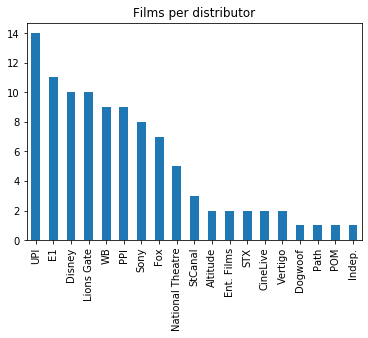

In [9]:
# Q1
(data
 .Distributor
 .value_counts()
 .plot.bar(title='Films per distributor')
)
plt.show()

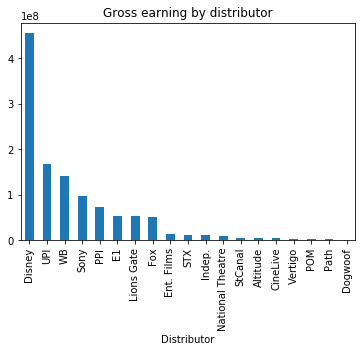

In [10]:
# Q2

# Remove the £ symbol and transform strings to integers
data['Gross'] = data['Gross'].apply(lambda x: int(x[1:].replace(',', '')))

# Group the data by Distributor and add the Gross value of their movies
(data
 .groupby('Distributor')
 ['Gross'].sum()
 .sort_values(ascending=False)
 .plot.bar(title='Gross earning by distributor')
)

plt.show()

## Exercise 2: Use Selenium to scrape Box Office Mojo's top #100 for every year between 2002 and 2019.

In [11]:
import selenium.webdriver
import sys
IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:  # WHEN USING THE NOTEBOOK LOCALLY (INSTALL SELENIUM FIRST)
    # You may need to pass `executable_path` 
    # See: https://github.com/SeleniumHQ/selenium/wiki/ChromeDriver
    driver = selenium.webdriver.Chrome()
else:  # WHEN USING THE NOTEBOOK ON COLAB
    # install chromium, its driver, and selenium
    !apt update
    !apt install chromium-chromedriver
    !pip install selenium
    # set options to be headless
    options = selenium.webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    # open it, go to a website, and get results
    driver = selenium.webdriver.Chrome('chromedriver',options=options)

In [12]:
def html2df(source, q):
    """A wrapper of the scraping pipeline we used before."""
    # Parse the HTML page
    soup = BeautifulSoup(source, 'html.parser')

    # Choose the relevant table
    table = soup.find_all('table')[4]

    # Parse and store the data of every table row
    lst = []
    for row in table.find_all('tr'):
        s = pd.Series([data.text for data in row.find_all('td')])
        lst.append(s)

    # Concatenate the data in a Pandas DataFrame and place the first row of the DataFrame as header.
    data = pd.concat(lst, axis=1).T

    # Grab the first row for the header
    new_header = data.iloc[0]

    # Take the data less the header row
    data = data[1:]

    # Set the header row as the df header
    data.columns = new_header
    
    # Add a new column tagging the page we scraped
    data['page'] = q 
    
    return data

In [13]:
url = 'https://www.boxofficemojo.com/intl/uk/yearly/'

In [14]:
# URL to use in Selenium
driver.get(url)

lst = []
# Loop over the years.
for i in range(2001, 2019):
    year = str(i + 1)
    # Locate Hyperlinks by partial link text
    elem = driver.find_element_by_partial_link_text(year)
    # Click on the next page
    elem.click()
    # Store the Pandas DataFrame with the scraped content in a list
    lst.append(html2df(driver.page_source, year))

# Concatenate all Pandas DataFrames
annual_top_100 = pd.concat(lst, sort=False)

In [15]:
annual_top_100.sample(10)

,Rank,Movie Title,Gross,Release,page,Distributor
41,41,The Day the Earth Stood Still (2008),"$10,901,777",12/12,2008,Fox
23,23,Fast and Furious,"$20,546,785",4/10,2009,UPI
45,45,Insidious,"$11,545,946",4/29,2011,Momentum
98,98,Get Rich or Die Tryin',"$3,699,933",1/20,2006,UIP
15,15,The Girl on the Train (2016),"$29,494,721",10/5,2016,E1
83,83,Robin Hood (2018),"$3,658,263",11/21,2018,Lions Gate
85,85,The Pact,"$4,031,952",6/8,2012,n/a
49,49,BlacKkKlansman,"$8,325,139",8/24,2018,UPI
15,15,The Holiday,"$23,942,753",12/8,2006,UIP
18,18,Moana,"$25,388,662",12/2,2016,Disney


In [16]:
print(f'% OF MISSING VALUES PER COLUMN\n{(annual_top_100.isnull().sum() / annual_top_100.shape[0]) * 100}')

% OF MISSING VALUES PER COLUMN
Rank            0.000000
Movie Title     0.000000
Gross           0.000000
Release         0.000000
page            0.000000
Distributor    11.111111
dtype: float64


In [17]:
print(f'(MOVIES, COLUMNS) -> {annual_top_100.shape}')

(MOVIES, COLUMNS) -> (1800, 6)
